In [33]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

from pandas import DataFrame, Series
from initializer import init
import utils

%matplotlib inline
plt.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

init()

# 1. Basic

## 1.1. Reminder

- cumulative return 산출

## 1.2. Weight

- 각 자산 비중(ratio)
- 특정 시점에서 항상 sum이 1이어야 함(진입 기준)
- e.g. Equal Weight Rebalancing

## 1.3. Return

- $ \text{Return of portfolio on day 1 } = {w_a}{r_a} + {w_b}{r_b} + {w_c}{r_c} + \dots $
- 1일 차의 $\sum$ (각 자신의 비중 * 각 자산의 return)

## 1.4. 중요한 포인트

- A 주가: [10, 12, 6](daily return: [+0.2, -0.5])
- B 주가: [10, 5, 6](daily return: [-0.5, +0.2])
- 각 10주씩 매수하고 buy & hold
---
- 위 1.3. 방식으로 수익률 계산하면...
  - 첫째날: `-0.15 (0.5 * 0.2 + 0.5 * -0.5)`
  - 둘째날: `-0.15 (0.5 * -0.5 + 0.5 * 0.2)`
  - 전체: `200 => 200 * (1 - 0.15) => 200 * (1 - 0.15)^2`
    - `[200, 170, 144.499999]`
---
- 그런데 포트폴리오 전체 value 관점에서 계산하면 `[200, 170, 120]`
  - 수익률은 `[0, -0.15, -0.294]`
---

> 첫째날이 지나면 포트폴리오의 weight가 달라지는 점을 유의하자.

### 1.4.1. Quiz

> 60:40 or 올웨더 전략 등 비중 기반 전략 진입 시, 비중만 유지하면 언제든 진입해도 될까?

안 되겠지

# 2. Buy & Hold

## 2.1. 구현

### 2.1.1. Data 준비

In [34]:
df = pd.DataFrame(
    {
        "A": [10, 15, 12, 13, 10, 11, 12],
        "B": [10, 10, 8, 13, 12, 12, 12],
        "C": [10, 12, 14, 16, 14, 14, 16],
    },
    index=pd.to_datetime(["2018-01-31", "2018-02-10", "2018-02-20", "2018-02-28", "2018-03-20", "2018-03-29", "2018-04-30",])
)
df

,A,B,C
2018-01-31,10,10,10
2018-02-10,15,10,12
2018-02-20,12,8,14
2018-02-28,13,13,16
2018-03-20,10,12,14
2018-03-29,11,12,14
2018-04-30,12,12,16


### 2.1.2. Shifted Return 구하기

In [35]:
"""이 상황에서는 Log Based Return을 사용할 수 없음을 기억하자"""
rtn_df = utils.get_returns_df(df, log=False)
rtn_df
"""shift 해야 해당 date에서 데이터를 가지고 있을 때 발생하는 수익률을 mapping 하기 쉬움"""
shifted_rtn_df = rtn_df.shift(-1).fillna(0)
shifted_rtn_df

'이 상황에서는 Log Based Return을 사용할 수 없음을 기억하자'

,A,B,C
2018-01-31,0.000,0.000,0.000
2018-02-10,0.500,0.000,0.200
2018-02-20,-0.200,-0.200,0.167
2018-02-28,0.083,0.625,0.143
2018-03-20,-0.231,-0.077,-0.125
2018-03-29,0.100,0.000,0.000
2018-04-30,0.091,0.000,0.143


'shift 해야 해당 date에서 데이터를 가지고 있을 때 발생하는 수익률을 mapping 하기 쉬움'

,A,B,C
2018-01-31,0.500,0.000,0.200
2018-02-10,-0.200,-0.200,0.167
2018-02-20,0.083,0.625,0.143
2018-02-28,-0.231,-0.077,-0.125
2018-03-20,0.100,0.000,0.000
2018-03-29,0.091,0.000,0.143
2018-04-30,0.000,0.000,0.000


In [36]:
cum_rtn_df = df / df.iloc[0]
cum_rtn_df

,A,B,C
2018-01-31,1.000,1.000,1.000
2018-02-10,1.500,1.000,1.200
2018-02-20,1.200,0.800,1.400
2018-02-28,1.300,1.300,1.600
2018-03-20,1.000,1.200,1.400
2018-03-29,1.100,1.200,1.400
2018-04-30,1.200,1.200,1.600


### 2.1.3. asset flow & weight df 구하기

In [37]:
"""A: 30%, B: 50%, C: 20%"""
WEIGHTS = [0.3, 0.5, 0.2]

assert sum(WEIGHTS) == 1

asset_flow_df = cum_rtn_df * WEIGHTS
asset_flow_df

'A: 30%, B: 50%, C: 20%'

,A,B,C
2018-01-31,0.300,0.500,0.200
2018-02-10,0.450,0.500,0.240
2018-02-20,0.360,0.400,0.280
2018-02-28,0.390,0.650,0.320
2018-03-20,0.300,0.600,0.280
2018-03-29,0.330,0.600,0.280
2018-04-30,0.360,0.600,0.320


In [38]:
port_weight_df = asset_flow_df.divide(asset_flow_df.sum(axis=1), axis=0)
port_weight_df

"""각 행의 값의 합은 항상 1로 유지"""
for i in range(len(port_weight_df)):
    assert sum(port_weight_df.iloc[i]) == 1
assert port_weight_df.sum(axis=1).sum() == len(port_weight_df)

,A,B,C
2018-01-31,0.300,0.500,0.200
2018-02-10,0.378,0.420,0.202
2018-02-20,0.346,0.385,0.269
2018-02-28,0.287,0.478,0.235
2018-03-20,0.254,0.508,0.237
2018-03-29,0.273,0.496,0.231
2018-04-30,0.281,0.469,0.250


'각 행의 값의 합은 항상 1로 유지'

### 2.1.4. 최종 portfolio return 구하기

In [39]:
net_rtn_df = port_weight_df * shifted_rtn_df
net_rtn_df

,A,B,C
2018-01-31,0.150,0.000,0.040
2018-02-10,-0.076,-0.084,0.034
2018-02-20,0.029,0.240,0.038
2018-02-28,-0.066,-0.037,-0.029
2018-03-20,0.025,0.000,0.000
2018-03-29,0.025,0.000,0.033
2018-04-30,0.000,0.000,0.000


In [40]:
"""계산을 위해 shift(-1) 했던 부분을 되돌리는 작업"""
net_rtn_df = net_rtn_df.shift(1).fillna(0)
net_rtn_df

'계산을 위해 shift(-1) 했던 부분을 되돌리는 작업'

,A,B,C
2018-01-31,0.000,0.000,0.000
2018-02-10,0.150,0.000,0.040
2018-02-20,-0.076,-0.084,0.034
2018-02-28,0.029,0.240,0.038
2018-03-20,-0.066,-0.037,-0.029
2018-03-29,0.025,0.000,0.000
2018-04-30,0.025,0.000,0.033


In [41]:
"""일별 포트폴리오 수익률 Series"""
rtn_series = net_rtn_df.sum(axis=1)
rtn_series

'일별 포트폴리오 수익률 Series'

2018-01-31    0.000
2018-02-10    0.190
2018-02-20   -0.126
2018-02-28    0.308
2018-03-20   -0.132
2018-03-29    0.025
2018-04-30    0.058
dtype: float64

'일별 포트폴리오 누적 수익률 Series'

2018-01-31   1.000
2018-02-10   1.190
2018-02-20   1.040
2018-02-28   1.360
2018-03-20   1.180
2018-03-29   1.210
2018-04-30   1.280
dtype: float64

<AxesSubplot:title={'center':'Buy & Hold 누적 수익률'}>

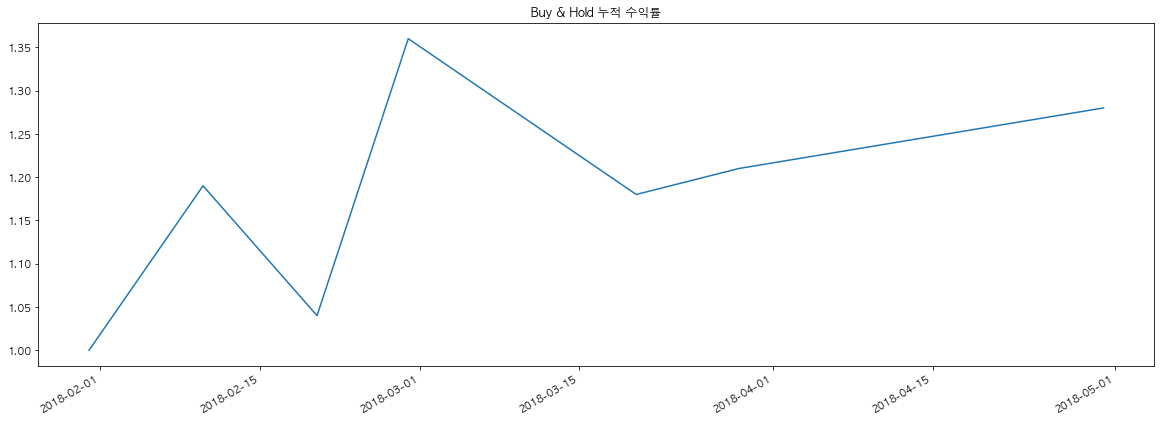

In [42]:
"""일별 포트폴리오 누적 수익률 Series"""
(rtn_series + 1).cumprod()
(rtn_series + 1).cumprod().plot(figsize=(20, 7), title="Buy & Hold 누적 수익률")

### 2.1.5. 개별종목 portval 구하기 - 두 번째 구현 방법

- "buy & hold"일 경우 이전에 구한 `asset_flow_df`와 동일

In [43]:
_df = pd.DataFrame({
    "A portval": [10, 12, 11, 5],
    "B portval": [40, 35, 37, 41],
    "Total portval": [50, 47, 48, 46]
})
_df

,A portval,B portval,Total portval
0,10,40,50
1,12,35,47
2,11,37,48
3,5,41,46


#### `asset_flow_df`가 개별 portval df인 이유 1

- $A(1 + r_{a1}) \rightarrow A(1 + r_{a1})(1 + r_{a2}) \rightarrow A(1 + r_{a1})(1 + r_{a2})(1 + r_{a3}) \rightarrow \dots$
- $0.1A(1 + r_{a1}) \rightarrow 0.1A(1 + r_{a1})(1 + r_{a2}) \rightarrow 0.1A(1 + r_{a1})(1 + r_{a2})(1 + r_{a3}) \rightarrow \dots$
- 처음 설정한 자산 $0.1A$에 $A$의 수익률이 그대로 복리 계산이 되기 때문에 계산이 망가지지 않는다.

In [44]:
individual_cum_rtn_df = cum_rtn_df * WEIGHTS
individual_cum_rtn_df

,A,B,C
2018-01-31,0.300,0.500,0.200
2018-02-10,0.450,0.500,0.240
2018-02-20,0.360,0.400,0.280
2018-02-28,0.390,0.650,0.320
2018-03-20,0.300,0.600,0.280
2018-03-29,0.330,0.600,0.280
2018-04-30,0.360,0.600,0.320


In [45]:
"""portval"""
individual_cum_rtn_df.sum(axis=1)

'portval'

2018-01-31   1.000
2018-02-10   1.190
2018-02-20   1.040
2018-02-28   1.360
2018-03-20   1.180
2018-03-29   1.210
2018-04-30   1.280
dtype: float64

#### `asset_flow_df`가 개별 portval df인 이유 2

> 직접 식으로 표현하고 비교하기 - e.g. A : B = 40 : 60 전략

##### individual 관점

- day 1
  - A: $0.4$
  - B: $0.6$
  - +: $1$
- day 2
  - A: $0.4(1 + r_{a1})$
  - B: $0.6(1 + r_{b1})$
  - +: $1 + 0.4r_{a1} + 0.6r_{b1}$
- day 3
  - A: $0.4(1 + r_{a1})(1 + r_{a2}) = 0.4(1 + r_{a1} + r_{a2} + r_{a1}r_{a2})$
  - B: $0.6(1 + r_{b1})(1 + r_{b2}) = 0.4(1 + r_{b1} + r_{b2} + r_{b1}r_{b2})$
  - +: $1 + 0.4(r_{a1} + r_{a2} + r_{a1}r_{a2}) + 0.6(r_{b1} + r_{b2} + r_{b1}r_{b2})$
    - $(1 + 0.4r_{a1} + 0.6r_{b1}) + 0.4(r_{a2} + r_{a1}r_{a2}) + 0.6(r_{b2} + r_{b1}r_{b2})$

##### portfolio 관점

- day 1
  - $1$
- day 2
  - $1 \times (1 + (0.4r_{a1} + 0.6r_{b1}))$
- day 3
  - $1 \times (1 + (0.4r_{a1} + 0.6r_{b1})) \times (1 + \dots)$

$$
\begin{aligned}
1 \times (1 + 0.4r_{a1} + 0.6r_{b1}) \times (1 + \dots)
&= 1 \times (1 + 0.4r_{a1} + 0.6r_{b1}) \times
(1 + \frac{0.4(1 + r_{a1}) \times r_{a2}}{0.4(1 + r_{a1}) + 0.6(1 + r_{b1})} + 
\frac{0.6(1 + r_{b1}) \times r_{b2}}{0.4(1 + r_{a1}) + 0.6(1 + r_{b1})})\\
&= 1 \times (1 + 0.4r_{a1} + 0.6r_{b1}) \times
(1 + \frac{0.4(1 + r_{a1}) \times r_{a2} + 0.6(1 + r_{b1}) \times r_{b2}}{0.4(1 + r_{a1}) + 0.6(1 + r_{b1})}) \\
&= 1 \times (1 + 0.4r_{a1} + 0.6r_{b1}) \times
(1 + \frac{0.4(1 + r_{a1}) \times r_{a2} + 0.6(1 + r_{b1}) \times r_{b2}}{1 + 0.4r_{a1} + 0.6r_{b1}}) \\
&= 1 \times ((1 + 0.4r_{a1} + 0.6r_{b1}) + (0.4(1 + r_{a1}) \times r_{a2} + 0.6(1 + r_{b1}) \times r_{b2})) \\
&= 1 \times (1 + 0.4r_{a1} + 0.6r_{b1} + 0.4r_{a2} + 0.4r_{a1}r_{a2} + 0.6r_{b2} + 0.6r_{b1}r_{b2}) \\
&= 1 \times ((1 + 0.4r_{a1} + 0.6r_{b1}) + (0.4(r_{a2} + r_{a1}r_{a2}) + 0.6(r_{b2} + r_{b1}r_{b2}))) \\
&= (1 + 0.4r_{a1} + 0.6r_{b1}) + 0.4(r_{a2} + r_{a1}r_{a2}) + 0.6(r_{b2} + r_{b1}r_{b2})
\end{aligned}
$$

## 2.2. 실수할 만한 내용

In [46]:
df.head()

,A,B,C
2018-01-31,10,10,10
2018-02-10,15,10,12
2018-02-20,12,8,14
2018-02-28,13,13,16
2018-03-20,10,12,14


In [50]:
rtn_df = utils.get_returns_df(df, log=False)
cum_rtn_df = df / df.iloc[0]

a_1 = (cum_rtn_df * (1 / 3)).sum(axis=1)
a_2 = ((rtn_df * (1 / 3)).sum(axis=1) + 1).cumprod()

"""왜 결과가 다를까"""
a_1
a_2

"""매일 반영된 weight가 틀어졌기 때문이다."""
"""cumulative * weight != return * weight"""

'왜 결과가 다를까'

2018-01-31   1.000
2018-02-10   1.233
2018-02-20   1.133
2018-02-28   1.400
2018-03-20   1.200
2018-03-29   1.233
2018-04-30   1.333
dtype: float64

2018-01-31   1.000
2018-02-10   1.233
2018-02-20   1.137
2018-02-28   1.460
2018-03-20   1.250
2018-03-29   1.291
2018-04-30   1.392
dtype: float64

'매일 반영된 weight가 틀어졌기 때문이다.'

'cumulative * weight != return * weight'

## 2.3. 주의사항

- 2018/1/1부터 0.5/0.5씩 들고 있는 것과 2018/10/1부터 0.5/0.5씩 들고 있는 것은 결과가 다르다.

In [51]:
df = pd.read_csv("class_materials/data/us_etf_1.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,IEF,QQQ,SHY,SPY,TLT
date_time,,,,,
2002-07-26,48.724,19.653,59.443,59.178,43.084
2002-07-29,48.153,20.658,59.245,61.989,42.504
2002-07-30,48.124,21.075,59.223,62.797,42.567
2002-07-31,48.565,20.676,59.406,62.976,43.094
2002-08-01,48.765,19.705,59.523,61.305,43.340


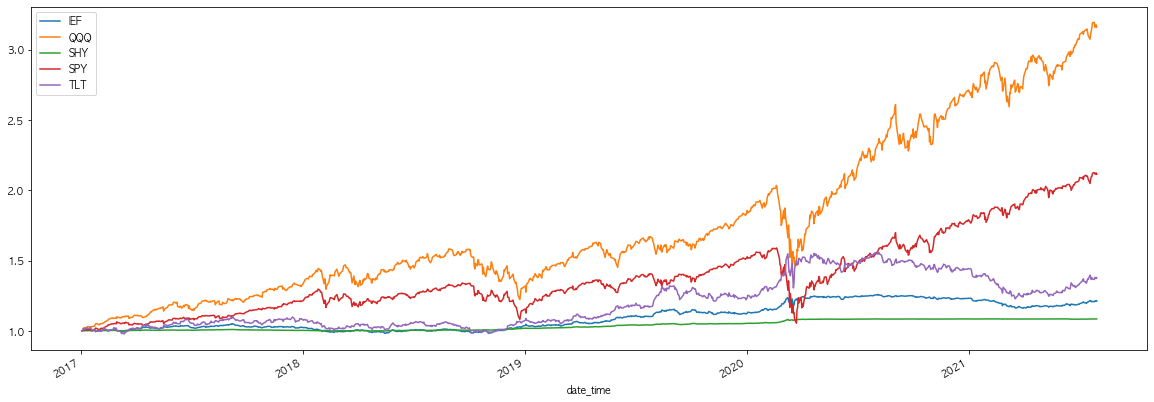

In [57]:
df_1 = df.loc["2017-01-01":]
cum_rtn_df = df_1 / df_1.iloc[0]

cum_rtn_df.plot(figsize=(20, 7));

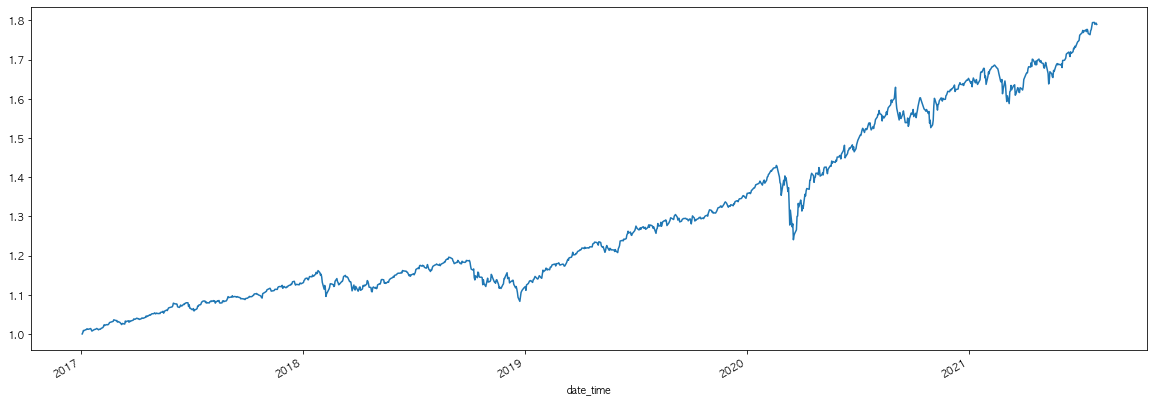

In [54]:
allocation = [0.2] * 5
allocation_df = cum_rtn_df * allocation

allocation_df.sum(axis=1).plot(figsize=(20, 7));

In [58]:
df_2 = cum_rtn_df.loc["2020-01-02":]
cum_rtn_df_2 = df_2 / df_2.iloc[0]
allocation_df_2 = cum_rtn_df_2 * allocation

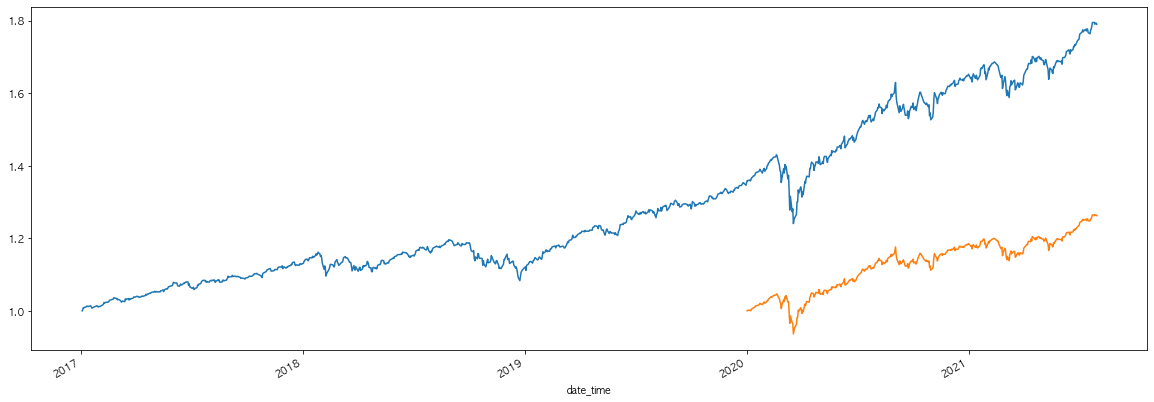

In [59]:
ax = allocation_df.sum(axis=1).plot(figsize=(20, 7))
allocation_df_2.sum(axis=1).plot(ax=ax);

In [60]:
allocation_df_2.head()

,IEF,QQQ,SHY,SPY,TLT
date_time,,,,,
2020-01-02,0.200,0.200,0.200,0.200,0.200
2020-01-03,0.201,0.198,0.200,0.198,0.203
2020-01-06,0.201,0.199,0.200,0.199,0.202
2020-01-07,0.201,0.199,0.200,0.199,0.201
2020-01-08,0.200,0.201,0.200,0.200,0.200


In [62]:
allocation_df.loc["2020-01-02"]
allocation_df.loc["2020-01-02"].sum()

IEF   0.225
QQQ   0.371
SHY   0.211
SPY   0.305
TLT   0.247
Name: 2020-01-02 00:00:00, dtype: float64

1.3588167271181084

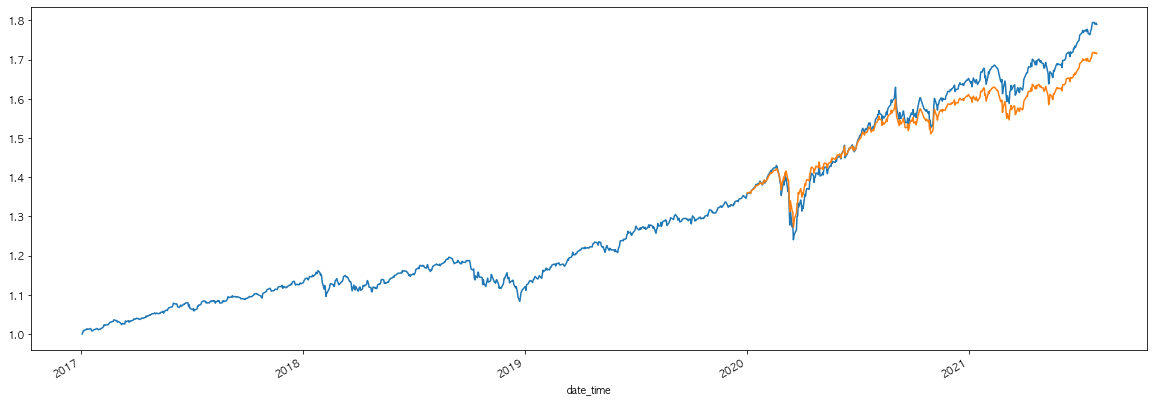

In [63]:
ax = allocation_df.sum(axis=1).plot(figsize=(20, 7))
(allocation_df_2.sum(axis=1) * allocation_df.loc["2020-01-02"].sum()).plot(ax=ax);